# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [34]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 8

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [46]:


n_samples = X_full.shape[0]

# random permutation of indices
indices = torch.randperm(n_samples)

# 70% training   30% testing
train_size = int(0.7 * n_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# spliting the data
X_train = X_full[train_indices]
y_train = y_full[train_indices]

X_val = X_full[val_indices]
y_val = y_full[val_indices]

print("Training samples:", X_train.shape)
print("Validation samples:", X_val.shape)


Training samples: torch.Size([2100, 2])
Validation samples: torch.Size([900, 2])


In [47]:
# activation function

def relu(x):
    return torch.maximum(x, torch.tensor(0.0))

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))



In [48]:
# forward pass

def forward(X):
    a1 = relu(X @ W1 + b1)
    a2 = relu(a1 @ W2 + b2)
    a3 = relu(a2 @ W3 + b3)
    y_hat = sigmoid(a3 @ W4 + b4)
    return y_hat


In [49]:
# initializing MLP parametres

input_dim = 2
hidden_dim = 16
output_dim = 1

W1 = torch.randn(input_dim, hidden_dim, requires_grad=True)
b1 = torch.zeros(hidden_dim, requires_grad=True)

W2 = torch.randn(hidden_dim, hidden_dim, requires_grad=True)
b2 = torch.zeros(hidden_dim, requires_grad=True)

W3 = torch.randn(hidden_dim, hidden_dim, requires_grad=True)
b3 = torch.zeros(hidden_dim, requires_grad=True)

W4 = torch.randn(hidden_dim, output_dim, requires_grad=True)
b4 = torch.zeros(output_dim, requires_grad=True)

# small init after creation
for W in [W1, W2, W3, W4]:
    W.data *= 0.1

parameters = [W1, b1, W2, b2, W3, b3, W4, b4]



In [50]:
with torch.no_grad():
    y_hat_train = forward(X_train)
    print("Mean prediction (train):", y_hat_train.mean().item())
    print("Min prediction:", y_hat_train.min().item())
    print("Max prediction:", y_hat_train.max().item())


Mean prediction (train): 0.5009348392486572
Min prediction: 0.5000231862068176
Max prediction: 0.5025879144668579


In [51]:
X_mean = X_train.mean(dim=0, keepdim=True)
X_std = X_train.std(dim=0, keepdim=True) + 1e-8

X_train = (X_train - X_mean) / X_std
X_val   = (X_val   - X_mean) / X_std


In [52]:
# binary cross entropy loss

def binary_cross_entropy(y_hat, y):
    eps = 1e-7
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    return -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat)).mean()


In [53]:
# calculating accuracy

def accuracy(y_hat, y):
    preds = (y_hat >= 0.5).float()
    return (preds == y).float().mean().item()


In [57]:
# training

epochs = 5500
lr_start = 0.05



train_losses, val_losses = [], []
train_accs, val_accs = [], []

# checking initial loss
print("Initial train loss:",
      binary_cross_entropy(forward(X_train), y_train).item())

for epoch in range(epochs):
    lr = lr_start * (0.95 ** (epoch // 700))

    # train
    y_hat = forward(X_train)
    train_loss = binary_cross_entropy(y_hat, y_train)
    train_acc = accuracy(y_hat, y_train)

    train_loss.backward()

    with torch.no_grad():
        for p in parameters:
            p -= lr * p.grad   # MUST be in-place
            p.grad.zero_()

    y_val_hat = forward(X_val)
    val_loss = binary_cross_entropy(y_val_hat, y_val)
    val_acc = accuracy(y_val_hat, y_val)

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if epoch % 700 == 0:
        print(f"Epoch {epoch} | "
              f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f}")

print("Final train loss:",
      binary_cross_entropy(forward(X_train), y_train).item())



Initial train loss: 0.33859750628471375
Epoch 0 | Train Acc: 0.888 | Val Acc: 0.872
Epoch 700 | Train Acc: 0.927 | Val Acc: 0.917
Epoch 1400 | Train Acc: 0.935 | Val Acc: 0.922
Epoch 2100 | Train Acc: 0.937 | Val Acc: 0.926
Epoch 2800 | Train Acc: 0.937 | Val Acc: 0.924
Epoch 3500 | Train Acc: 0.937 | Val Acc: 0.926
Epoch 4200 | Train Acc: 0.937 | Val Acc: 0.926
Epoch 4900 | Train Acc: 0.937 | Val Acc: 0.926
Final train loss: 0.2539122700691223


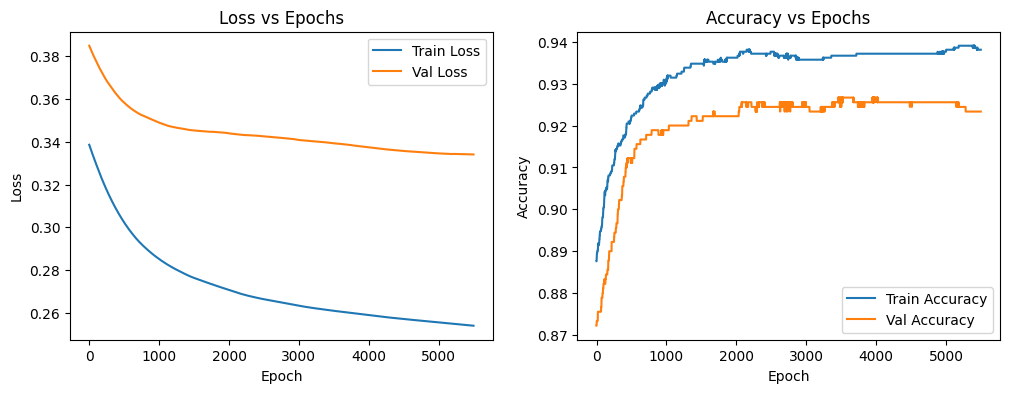

In [58]:

# loss and accuracy Plots
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")

# accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")

plt.show()


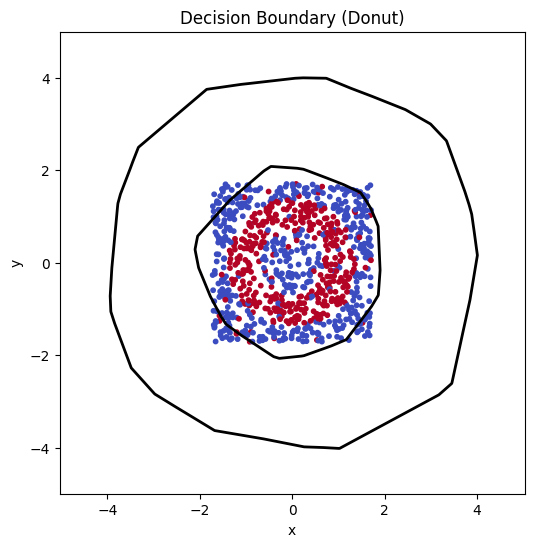

In [59]:
# decision boundary
xx, yy = np.meshgrid(
    np.linspace(-5, 5, 600),
    np.linspace(-5, 5, 600)
)

grid = torch.tensor(
    np.c_[xx.ravel(), yy.ravel()],
    dtype=torch.float32
)

# Normalize grid using training statistics
grid = (grid - X_mean) / X_std

with torch.no_grad():
    probs = forward(grid).reshape(xx.shape)

plt.figure(figsize=(6, 6))

# Decision boundary at probability = 0.5
plt.contour(xx, yy, probs, levels=[0.5], colors="black", linewidths=2)

# validation data points
plt.scatter(
    X_val[:, 0], X_val[:, 1],
    c=y_val[:, 0],
    cmap="coolwarm",
    s=10
)

plt.title("Decision Boundary (Donut)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

